In [2]:
import altair as alt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS
import os

def get_file_path(relative_path):
    parent_dir = os.getcwd()
    return os.path.join(parent_dir, relative_path)

pd.set_option('display.float_format', '{:.4f}'.format)

melt_path = 'melted_panel.csv'
panel_data = pd.read_csv(get_file_path(melt_path))
panel_data['Date'] = pd.to_datetime(panel_data['Date'])
print(panel_data.head())

           ISIN       Date  return  strike  ridle  cintensity  cratio    d2e  \
0  KYG367381053 1983-08-09  0.0000  0.0000 0.0000      0.0000  0.0000 0.0000   
1  KYG367381053 1983-08-10  0.0000  0.0000 0.0000      0.0000  0.0000 0.0000   
2  KYG367381053 1983-08-11  0.0000  0.0000 0.0000      0.0000  0.0000 0.0000   
3  KYG367381053 1983-08-12  0.0000  0.0000 0.0000      0.0000  0.0000 0.0000   
4  KYG367381053 1983-08-15  0.0000  0.0000 0.0000      0.0000  0.0000 0.0000   

   leadup  followup  5day_std  std_of_std  cum_returns  rolling_avg    spr  \
0  0.0000    0.0000    0.0000      0.0000       0.0000       0.0000 0.0060   
1  0.0000    0.0000    0.0000      0.0000       0.0000       0.0000 0.0088   
2  0.0000    0.0000    0.0000      0.0000       0.0000       0.0000 0.0001   
3  0.0000    0.0000    0.0000      0.0000       0.0000       0.0000 0.0038   
4  0.0000    0.0000    0.0000      0.0000       0.0000       0.0000 0.0096   

                         Industry  
0  Transportat

In [3]:
panel_data['ra'] = panel_data['return'].shift(periods=1).rolling(window=15).mean()
strike_mask = panel_data['leadup'] + panel_data['strike'] + panel_data['followup']
numeric_cols = panel_data.select_dtypes(include=[np.number])
numeric_cols = numeric_cols.multiply(strike_mask, axis=0)
non_numeric_cols = panel_data.select_dtypes(exclude=[np.number])
filtered_panel_data = pd.concat([non_numeric_cols, numeric_cols], axis=1)
filtered_panel_data.to_csv(get_file_path('melted_dumb_panel.csv'), index=False)

In [4]:
melt_path = 'melted_dumb_panel.csv'
filtered_panel_data = pd.read_csv(get_file_path(melt_path), parse_dates=['Date'], index_col=['ISIN', 'Date'])

In [5]:
pd.set_option('display.float_format', '{:.4f}'.format)

unique_industries = filtered_panel_data['Industry'].unique()
industry_estimates = pd.DataFrame(index=unique_industries)

for industry in unique_industries:
    print(f"\n--- Regression Results for Industry: {industry} ---\n")
    industry_data = filtered_panel_data[filtered_panel_data['Industry'] == industry]

    formula = 'return - spr ~ 1 + leadup + strike + ridle + cintensity + d2e'
    mod = PanelOLS.from_formula(formula, industry_data, check_rank=False, drop_absorbed=True)
    res = mod.fit(cov_type='clustered', cluster_entity=True)

    # Storing parameter estimate and standard error for 'ridle'
    industry_estimates.loc[industry, 'ridle'] = res.params.get('ridle', float('nan'))
    industry_estimates.loc[industry, 's_ridle'] = res.std_errors.get('ridle', float('nan'))

    # Storing the p-value for 'ridle'
    industry_estimates.loc[industry, 'p_ridle'] = res.pvalues.get('ridle', float('nan'))

    print(res.summary.tables[1])

# Displaying the DataFrame with estimates, standard errors, and p-values
print(industry_estimates)



--- Regression Results for Industry: Transportation and Warehousing ---

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept   3.479e-06  1.411e-06     2.4660     0.0137   7.139e-07   6.245e-06
leadup        -0.0018     0.0018    -1.0100     0.3125     -0.0053      0.0017
strike        -0.0011     0.0017    -0.6711     0.5021     -0.0044      0.0021
ridle          0.3647     0.1220     2.9895     0.0028      0.1256      0.6038
cintensity     0.0026     0.0022     1.1669     0.2433     -0.0018      0.0070
d2e           -0.0013     0.0012    -1.0627     0.2879     -0.0036      0.0011

--- Regression Results for Industry: Manufacturing ---

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI


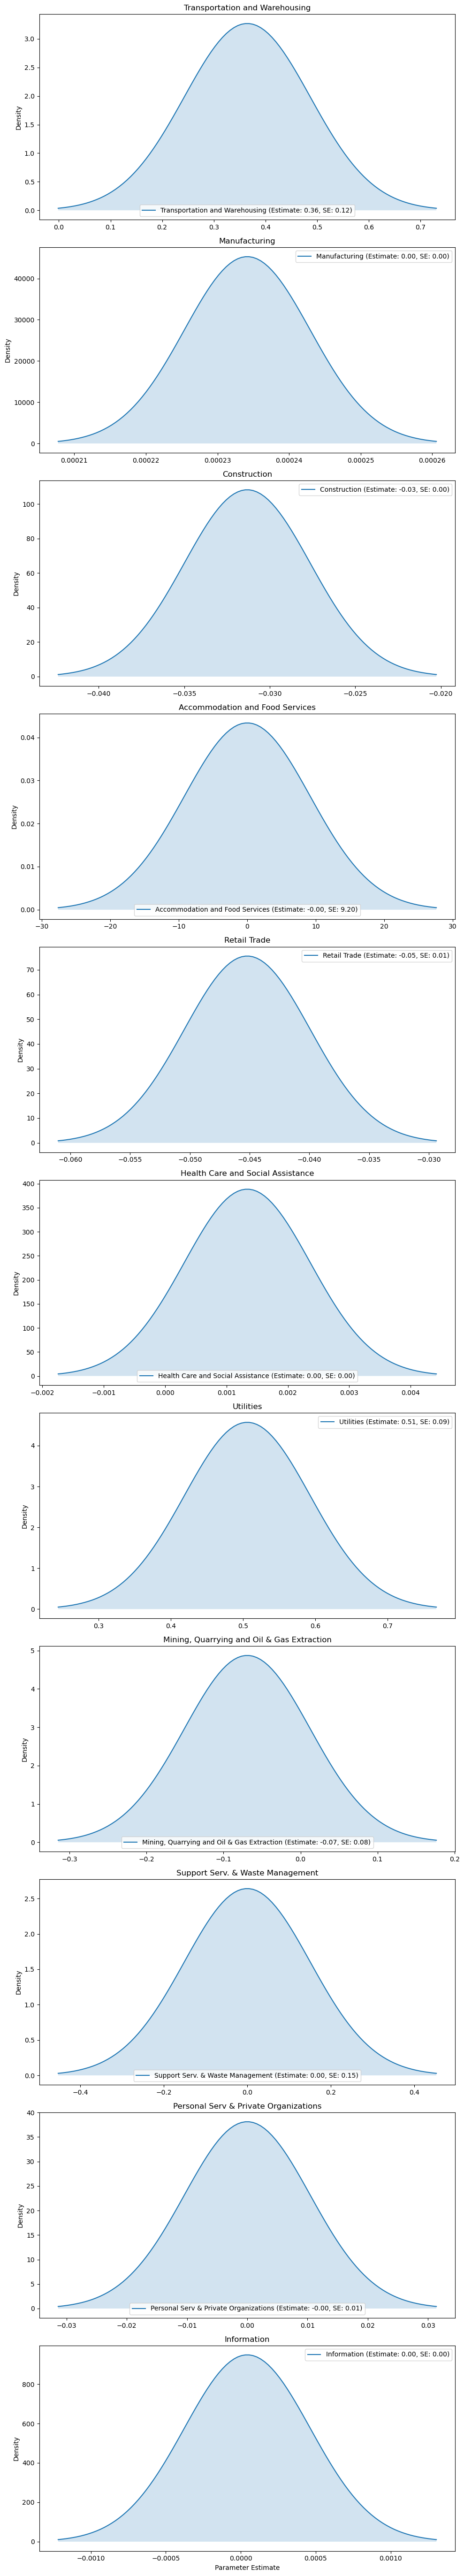

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Assuming 'industry_estimates' DataFrame has columns 'strike' for estimates and 's_ridle' for standard errors
n_industries = len(industry_estimates)

fig, axes = plt.subplots(n_industries, 1, figsize=(10, 5 * n_industries))

for i, (industry, row) in enumerate(industry_estimates.iterrows()):
    mu = row['ridle']
    sigma = row['s_ridle']
    
    # Generating points for the bell curve
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = norm.pdf(x, mu, sigma)

    axes[i].plot(x, y, label=f'{industry} (Estimate: {mu:.2f}, SE: {sigma:.2f})')
    axes[i].fill_between(x, y, alpha=0.2)
    axes[i].legend()
    axes[i].set_title(industry)
    axes[i].set_ylabel('Density')

plt.xlabel('Parameter Estimate')
plt.tight_layout()
plt.show()


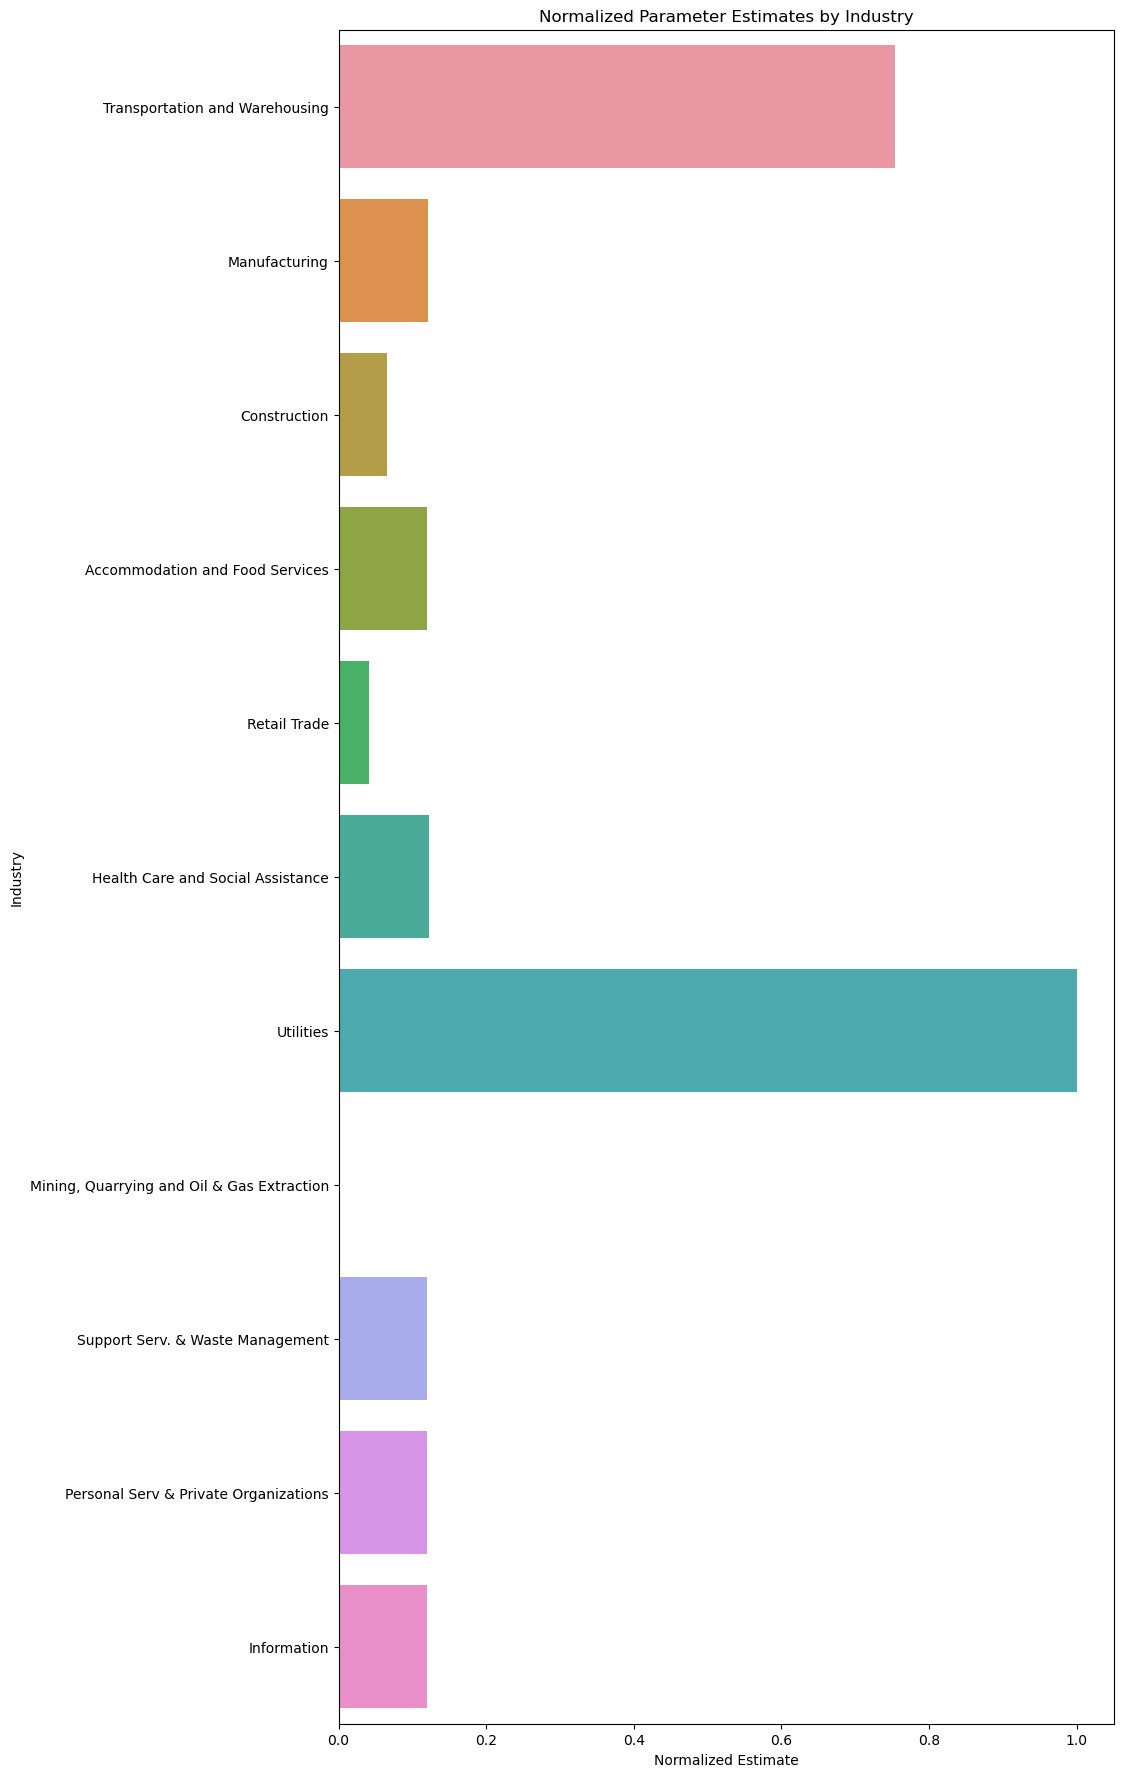

In [7]:

from sklearn.preprocessing import MinMaxScaler

# Assuming 'industry_estimates' DataFrame is already created

# Normalize the parameter estimates
scaler = MinMaxScaler()
industry_estimates['normalized_strike'] = scaler.fit_transform(industry_estimates[['ridle']])

n_industries = len(industry_estimates)
fig, ax = plt.subplots(figsize=(10, n_industries * 2))

# Plot normalized estimates
sns.barplot(x='normalized_strike', y=industry_estimates.index, data=industry_estimates, ax=ax)

plt.title('Normalized Parameter Estimates by Industry')
plt.xlabel('Normalized Estimate')
plt.ylabel('Industry')
plt.show()

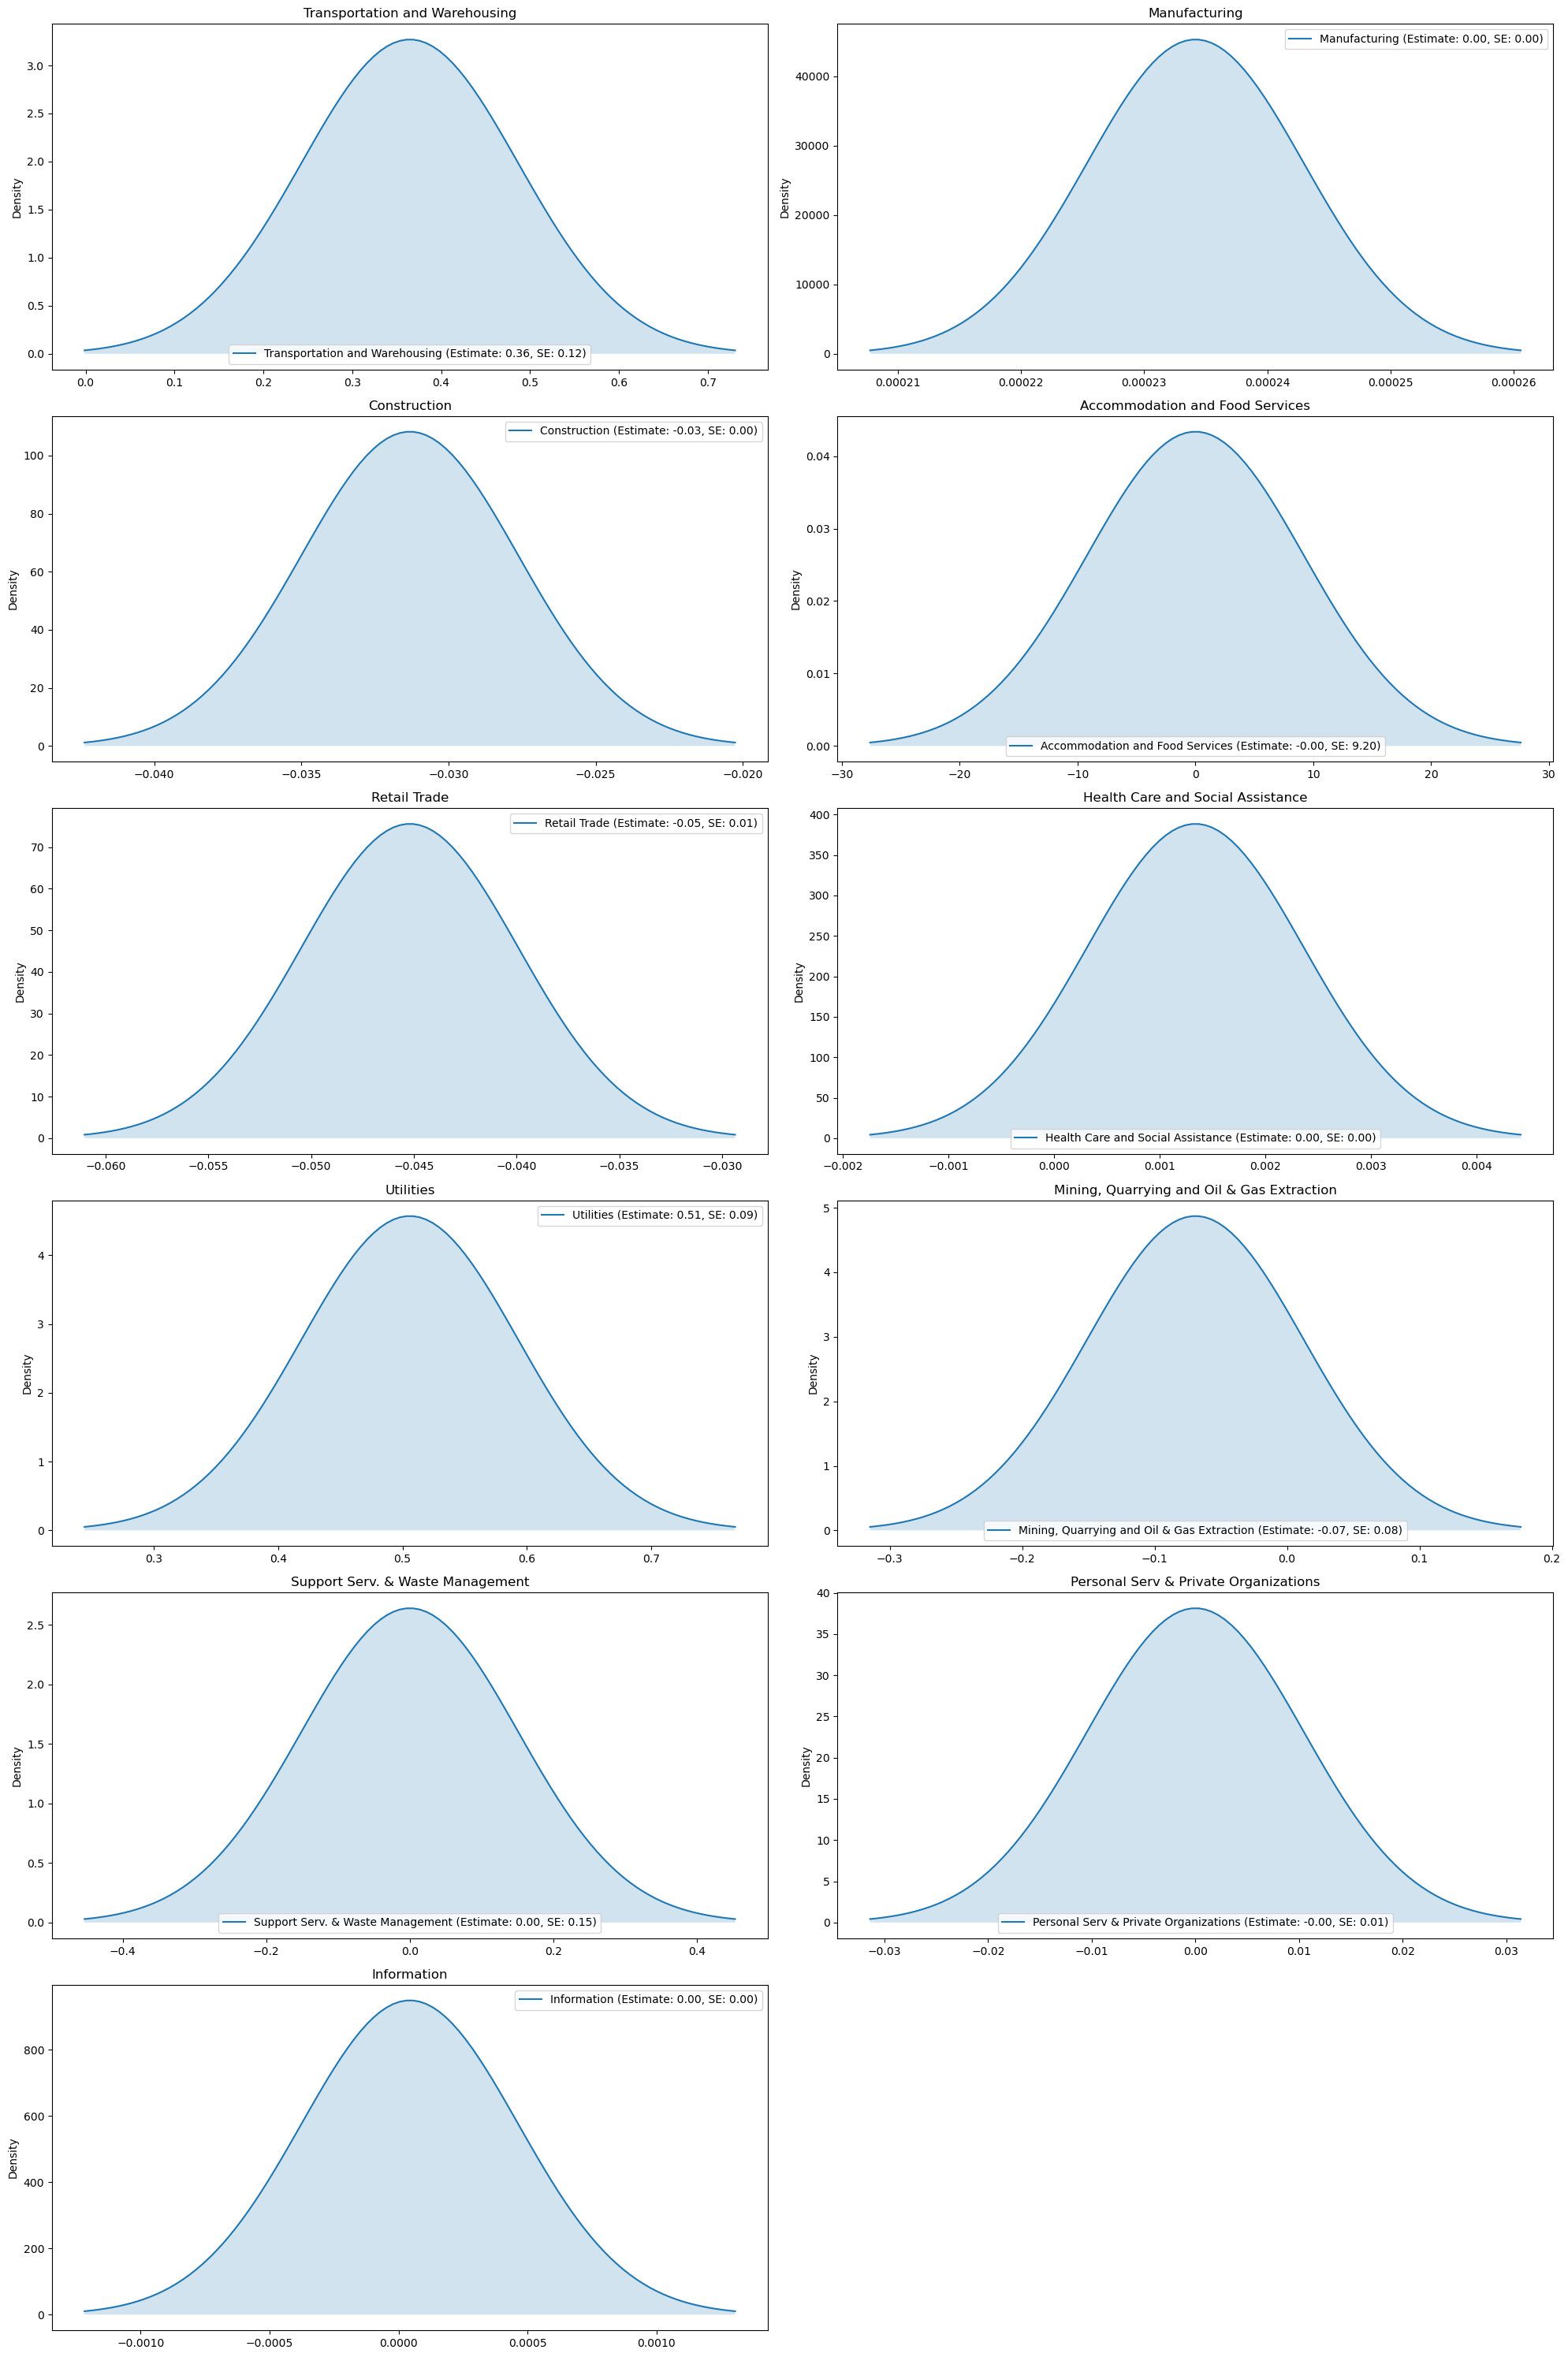

In [8]:
n_industries = len(industry_estimates)
rows = int(np.ceil(n_industries / 2))
cols = 2 if n_industries > 1 else 1

fig, axes = plt.subplots(rows, cols, figsize=(10 * cols, 5 * rows))
axes = axes.flatten()

for i, (industry, row) in enumerate(industry_estimates.iterrows()):
    ax = axes[i]
    mu = row['ridle']
    sigma = row['s_ridle']
    
    # Generating points for the bell curve
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = norm.pdf(x, mu, sigma)

    ax.plot(x, y, label=f'{industry} (Estimate: {mu:.2f}, SE: {sigma:.2f})')
    ax.fill_between(x, y, alpha=0.2)
    ax.set_title(industry)
    ax.set_ylabel('Density')
    ax.legend()

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

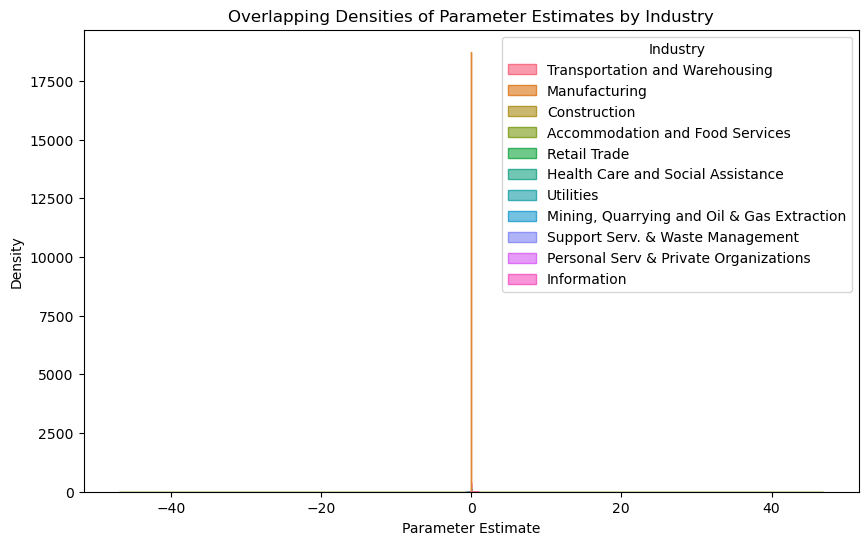

In [9]:
plot_data = pd.DataFrame()

for industry, row in industry_estimates.iterrows():
    mu = row['ridle']
    sigma = row['s_ridle']

    # Generating points for the bell curve
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = norm.pdf(x, mu, sigma)

    # Append to the DataFrame
    temp_df = pd.DataFrame({'Value': x, 'Density': y, 'Industry': industry})
    plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

# Create the ridge plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=plot_data, x='Value', hue='Industry', fill=True, common_norm=False, alpha=0.7)

plt.title('Overlapping Densities of Parameter Estimates by Industry')
plt.xlabel('Parameter Estimate')
plt.ylabel('Density')
plt.show()

/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/ivankhalin/anaconda3/lib/python3.11/site-pac

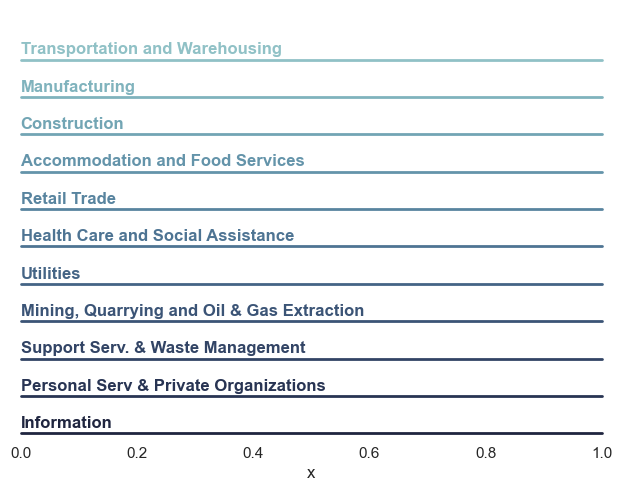

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Assuming 'industry_estimates' DataFrame has columns 'ridle' for estimates and 's_ridle' for standard errors

# Create the data for the plot
plot_data = pd.DataFrame()
for industry, row in industry_estimates.iterrows():
    mu = row['ridle']
    sigma = row['s_ridle']
    sigma = max(sigma, 1e-3)

    # Generating points for the bell curve
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1)
    y = norm.pdf(x, mu, sigma)

    # Append to the DataFrame
    temp_df = pd.DataFrame({'x': x, 'Density': y, 'Industry': industry})
    plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(len(industry_estimates), rot=-.25, light=.7)
g = sns.FacetGrid(plot_data, row="Industry", hue="Industry", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.show()


/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/ivankhalin/anaconda3/lib/python3.11/site-pac

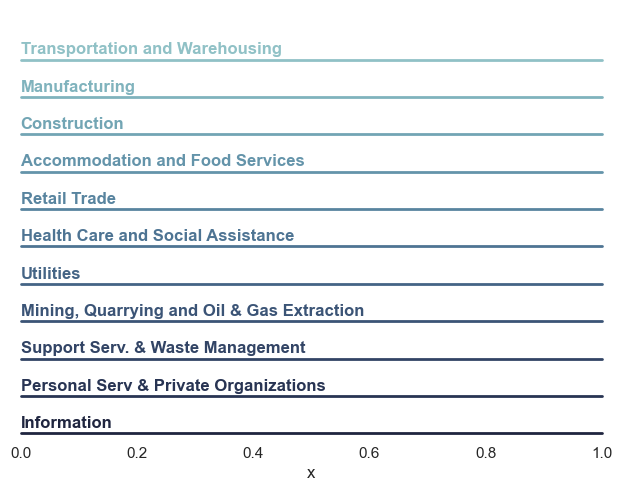

In [11]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Assuming 'industry_estimates' DataFrame has columns 'strike' for estimates and 's_ridle' for standard errors

# Create the data for the plot
plot_data = pd.DataFrame()
for industry, row in industry_estimates.iterrows():
    mu = row['ridle']
    sigma = row['s_ridle']

    # Adjust the range of x based on the actual data spread
    x_min, x_max = mu - 2*sigma, mu + 2*sigma
    x = np.linspace(x_min, x_max, 1)/10
    y = norm.pdf(x, mu, sigma)

    # Append to the DataFrame
    temp_df = pd.DataFrame({'x': x, 'Density': y, 'Industry': industry})
    plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(len(industry_estimates), rot=-.25, light=.7)
g = sns.FacetGrid(plot_data, row="Industry", hue="Industry", aspect=15, height=.5, palette=pal)

# Draw the densities
g.map(sns.kdeplot, "x", bw_adjust=0.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=0.5)

# Refline
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Label function
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Adjust plot
g.figure.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.show()

/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args

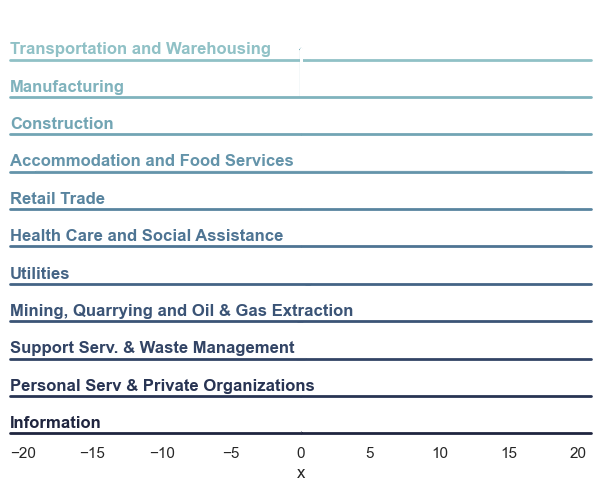

In [12]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Assuming 'industry_estimates' DataFrame has columns 'strike' for estimates and 's_ridle' for standard errors

# Create the data for the plot
plot_data = pd.DataFrame()
for industry, row in industry_estimates.iterrows():
    mu = row['ridle']
    sigma = row['s_ridle']

    # Adjust the range of x based on the actual data spread
    x_min, x_max = mu - 2*sigma, mu + 2*sigma
    x = np.linspace(x_min, x_max, 100)
    y = norm.pdf(x, mu, sigma)

    # Append to the DataFrame
    temp_df = pd.DataFrame({'x': x, 'Density': y, 'Industry': industry})
    plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(len(industry_estimates), rot=-.25, light=.7)
g = sns.FacetGrid(plot_data, row="Industry", hue="Industry", aspect=15, height=.5, palette=pal)

# Draw the densities
g.map(sns.kdeplot, "x", bw_adjust=0.05, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=0.05)

# Refline
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Label function
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Adjust plot
g.figure.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.show()

/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args

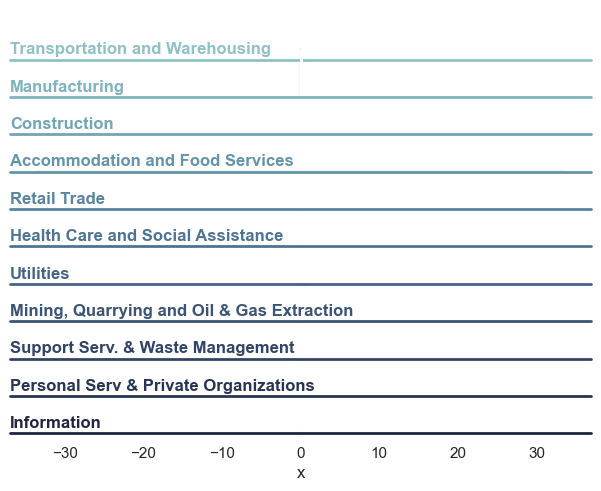

In [13]:
plot_data = pd.DataFrame()
for industry, row in industry_estimates.iterrows():
    mu = row['ridle']
    sigma = row['s_ridle']

    # Use dynamic x-axis limits based on the parameter estimates and standard errors
    x_min, x_max = mu - 3 * sigma, mu + 3 * sigma
    x = np.linspace(x_min, x_max, 1000)
    y = norm.pdf(x, mu, sigma)

    # Append to the DataFrame
    temp_df = pd.DataFrame({'x': x, 'Density': y, 'Industry': industry})
    plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(len(industry_estimates), rot=-.25, light=.7)
g = sns.FacetGrid(plot_data, row="Industry", hue="Industry", aspect=15, height=.5, palette=pal)

# Draw the densities
g.map(sns.kdeplot, "x",
      bw_adjust=0.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=0.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.show()

/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/ivankhalin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/ivankhalin/anaconda3/lib/python3.11/site-pac

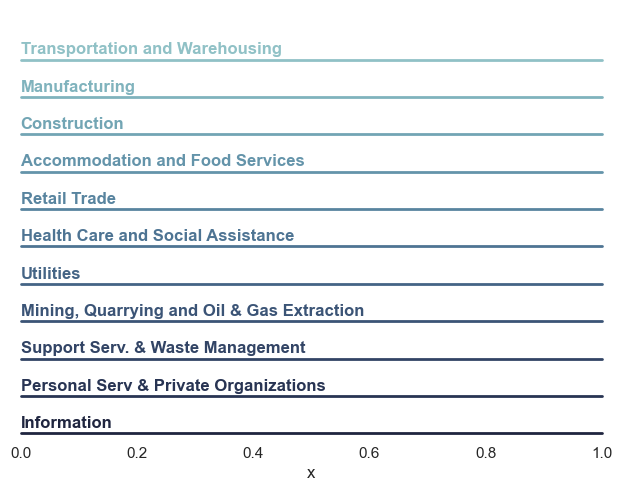

In [14]:
plot_data = pd.DataFrame()
max_density_values = {}  # To store the max density for each industry

for industry, row in industry_estimates.iterrows():
    mu = row['ridle']
    sigma = row['s_ridle']

    # Ensure sigma is not zero to avoid division by zero in norm.pdf
    sigma = max(sigma, 1e-3)

    x_min, x_max = mu - 3 * sigma, mu + 3 * sigma
    x = np.linspace(x_min, x_max, 1)
    y = norm.pdf(x, mu, sigma)
    max_density_values[industry] = y.max()  # Store the max density

    temp_df = pd.DataFrame({'x': x, 'Density': y, 'Industry': industry})
    plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(len(industry_estimates), rot=-.25, light=.7)
g = sns.FacetGrid(plot_data, row="Industry", hue="Industry", aspect=15, height=.5, palette=pal)

# Draw the densities
g.map(sns.kdeplot, "x", bw_adjust=0.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)

# Now adjust y-limits for each subplot
for ax, industry in zip(g.axes.flat, industry_estimates.index):
    ax.set_ylim(0, max_density_values[industry] * 1.1)  # Give some padding above the max

g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=0.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.show()

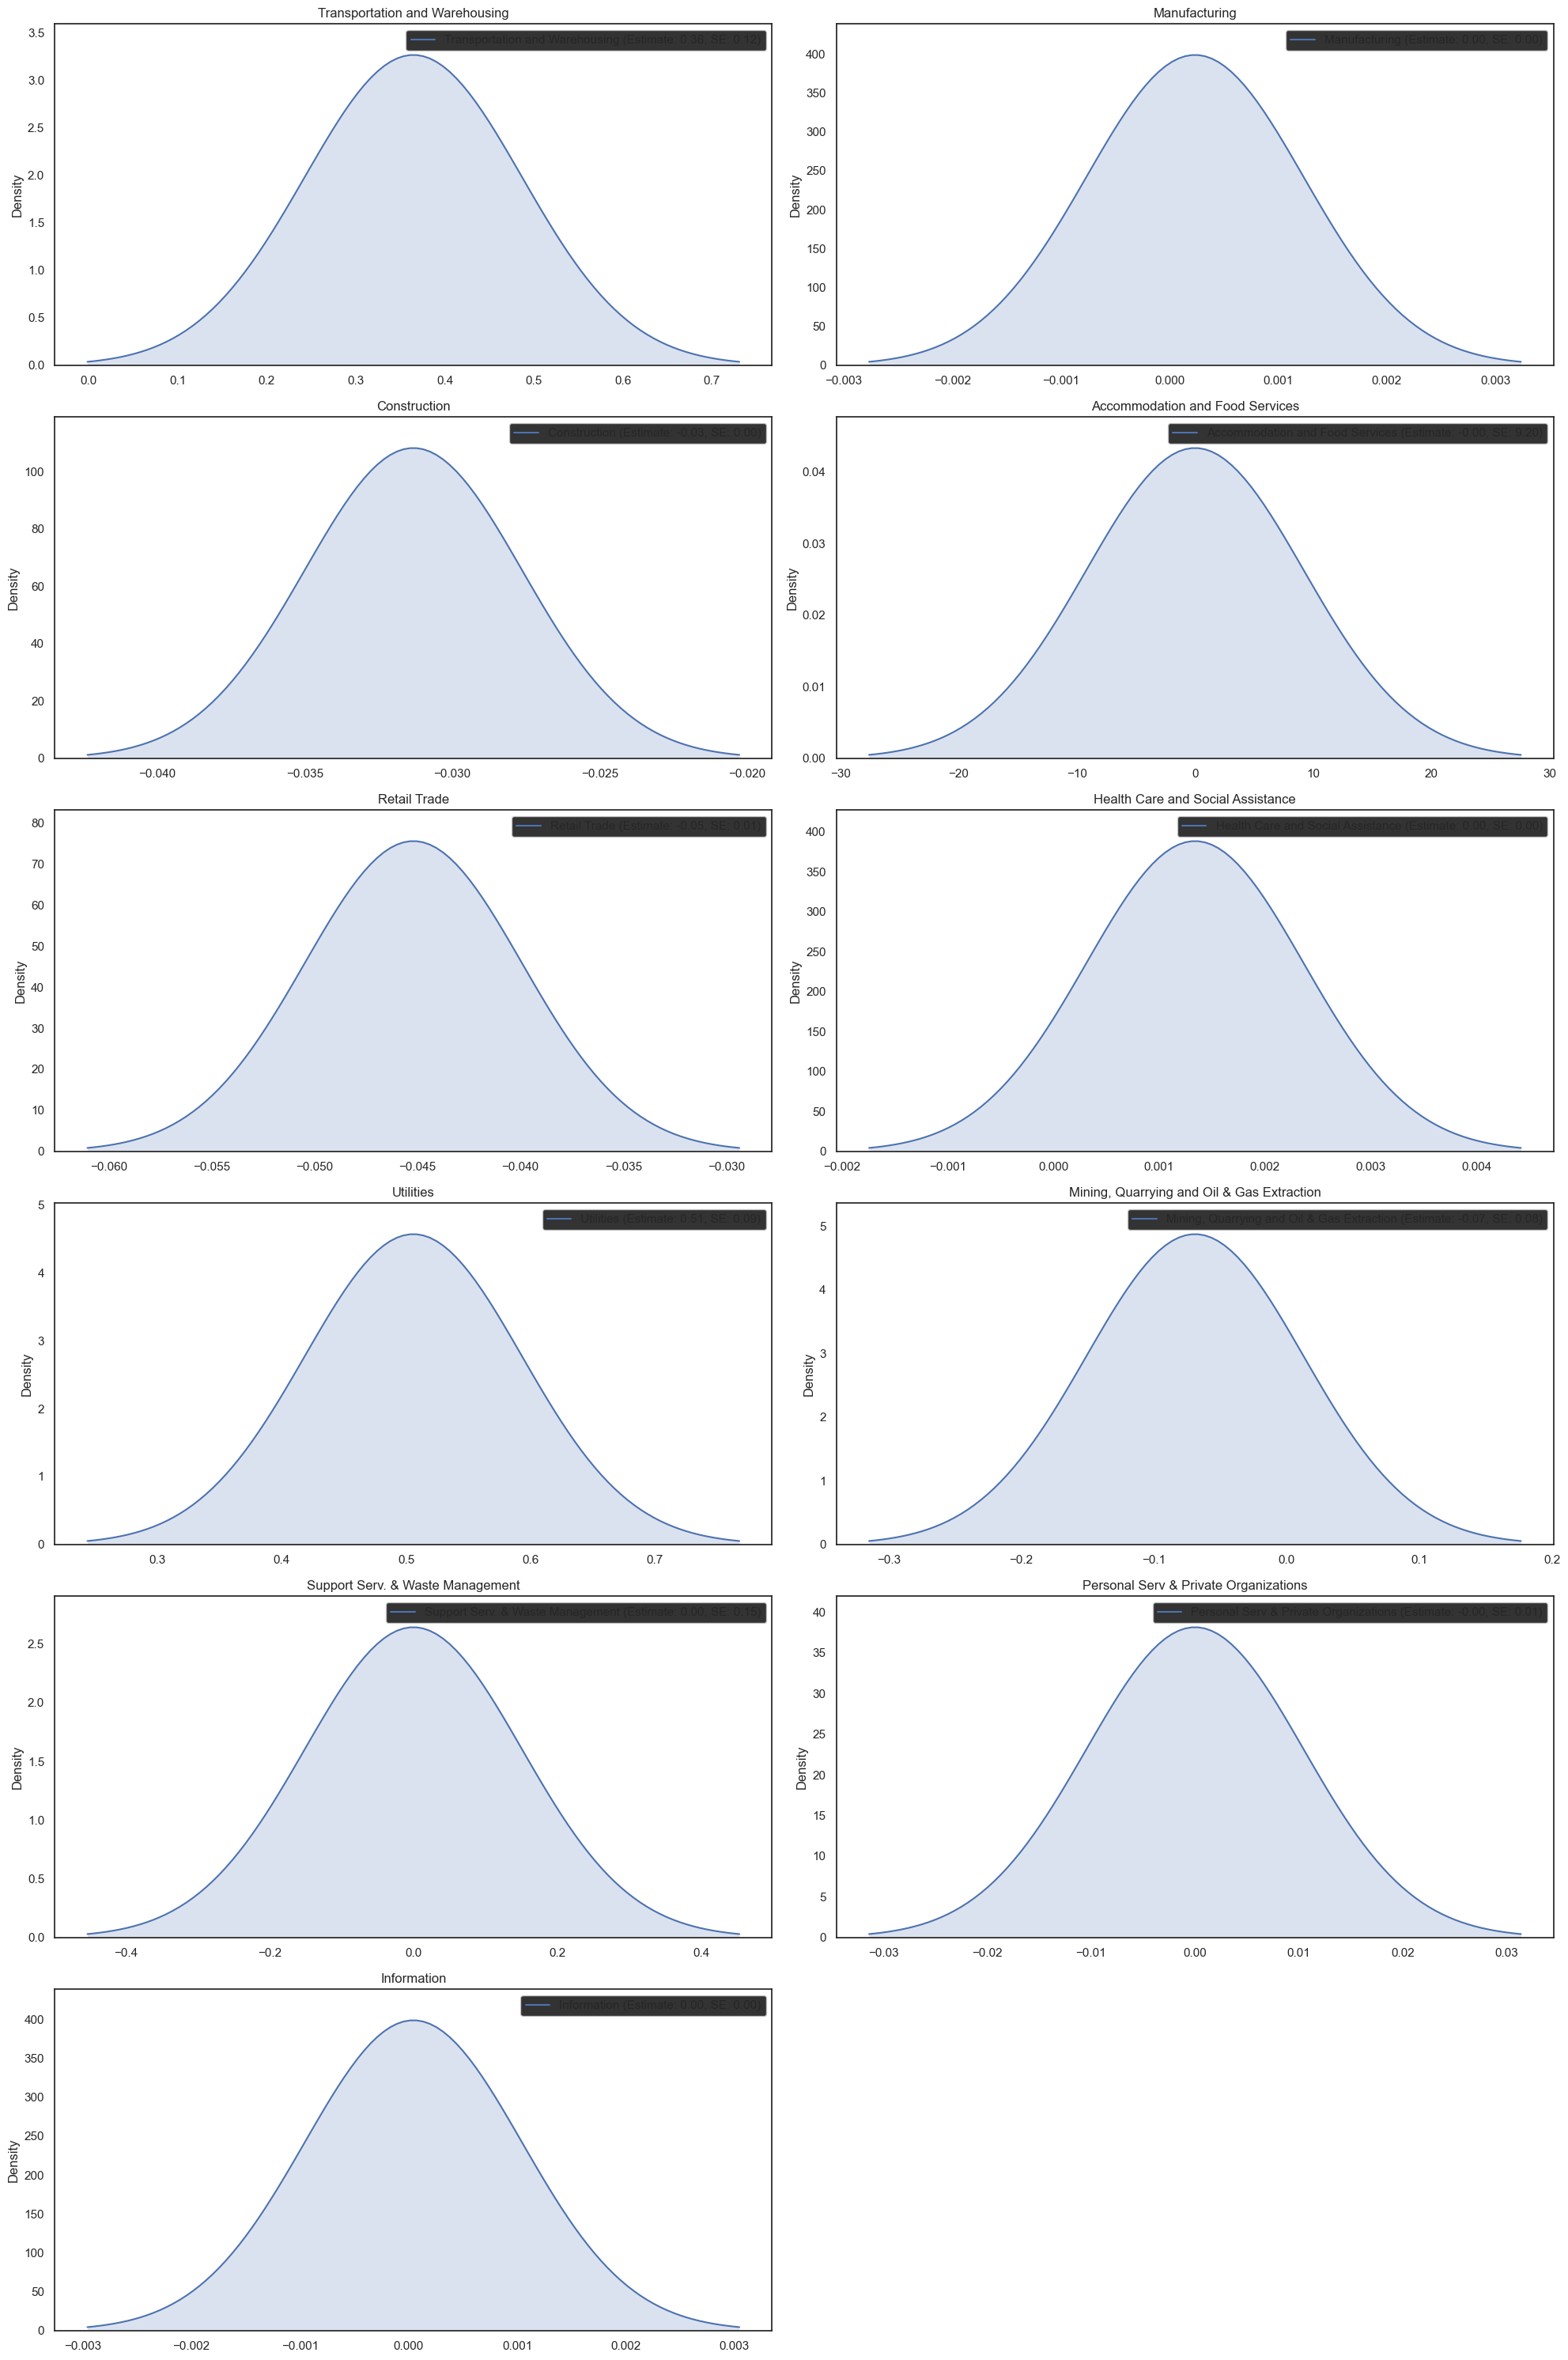

In [15]:
n_industries = len(industry_estimates)
rows = int(np.ceil(n_industries / 2))
cols = 2 if n_industries > 1 else 1

fig, axes = plt.subplots(rows, cols, figsize=(10 * cols, 5 * rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, (industry, row) in enumerate(industry_estimates.iterrows()):
    ax = axes[i]
    mu = row['ridle']
    sigma = row['s_ridle']

    # Ensure sigma is not zero to avoid division by zero in norm.pdf
    sigma = max(sigma, 1e-3)

    # Generating points for the bell curve
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = norm.pdf(x, mu, sigma)
    
    # Find the peak y-value to set the y-limit accordingly
    peak_y = np.max(y)

    ax.plot(x, y, label=f'{industry} (Estimate: {mu:.2f}, SE: {sigma:.2f})')
    ax.fill_between(x, y, alpha=0.2)
    ax.set_title(industry)
    ax.set_ylim(0, peak_y * 1.1)  # Extend y-limit slightly above the peak
    ax.set_ylabel('Density')
    ax.legend()

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

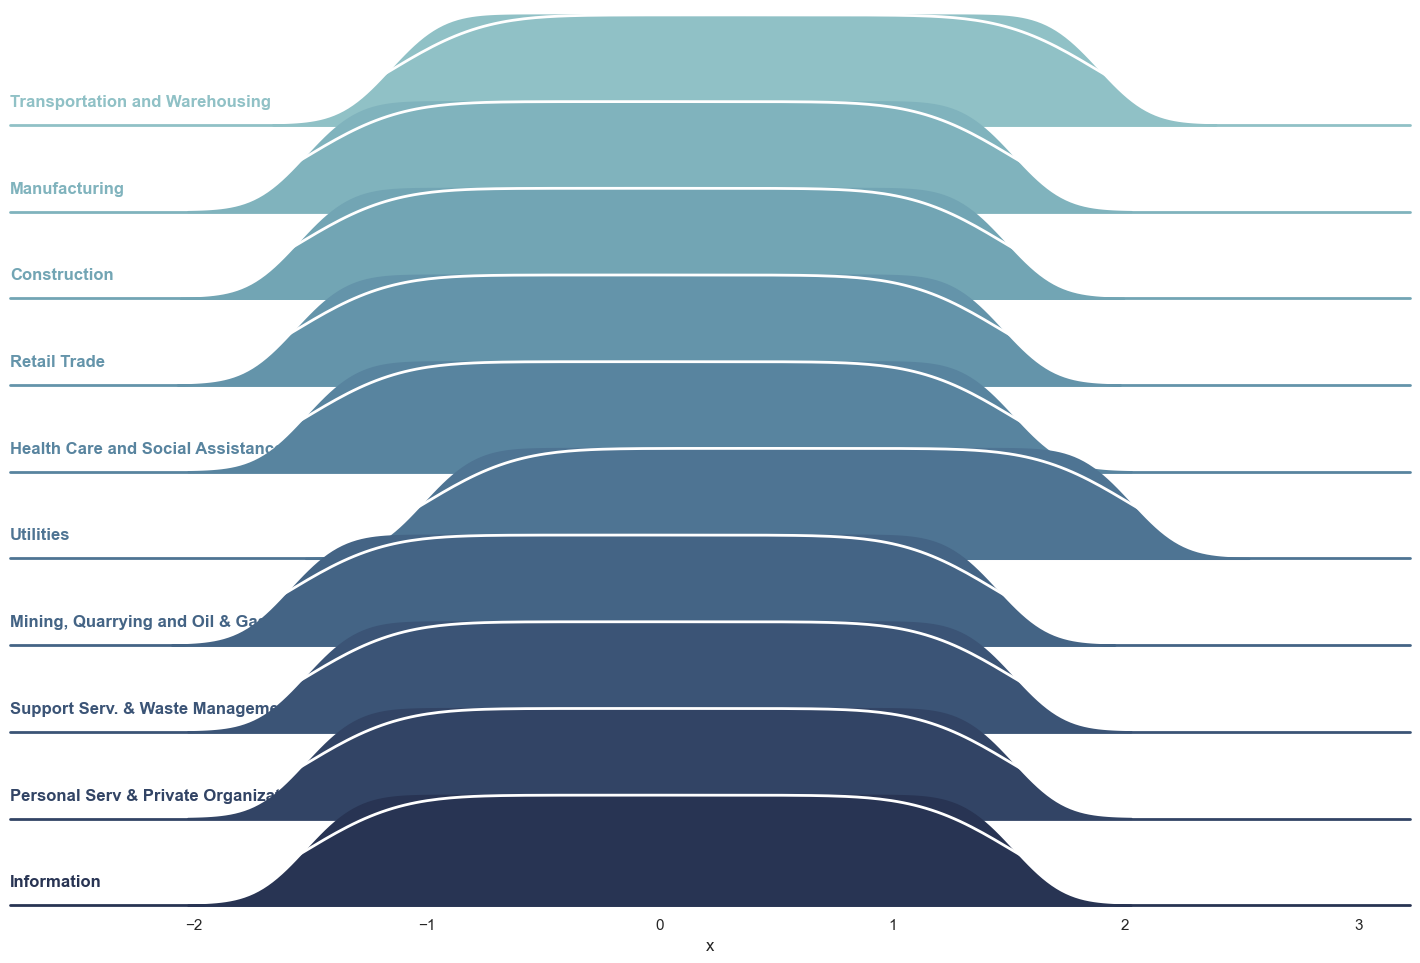

In [16]:
plot_data = pd.DataFrame()

for industry, row in industry_estimates.iterrows():
    if industry == 'Accommodation and Food Services':
        continue
    mu = row['ridle']
    sigma = row['s_ridle']
    # Ensure sigma is not too small to avoid zero variance
    sigma = max(sigma, 0.5)

    # Generating points for the bell curve
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = norm.pdf(x, mu, sigma)

    # Append to the DataFrame
    temp_df = pd.DataFrame({'x': x, 'Density': y, 'Industry': industry})
    plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(len(industry_estimates), rot=-.25, light=.7)
# Increase the height parameter if needed
g = sns.FacetGrid(plot_data, row="Industry", hue="Industry", aspect=15, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.9)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
# g.set(xlim=(-10, 10))

plt.show()

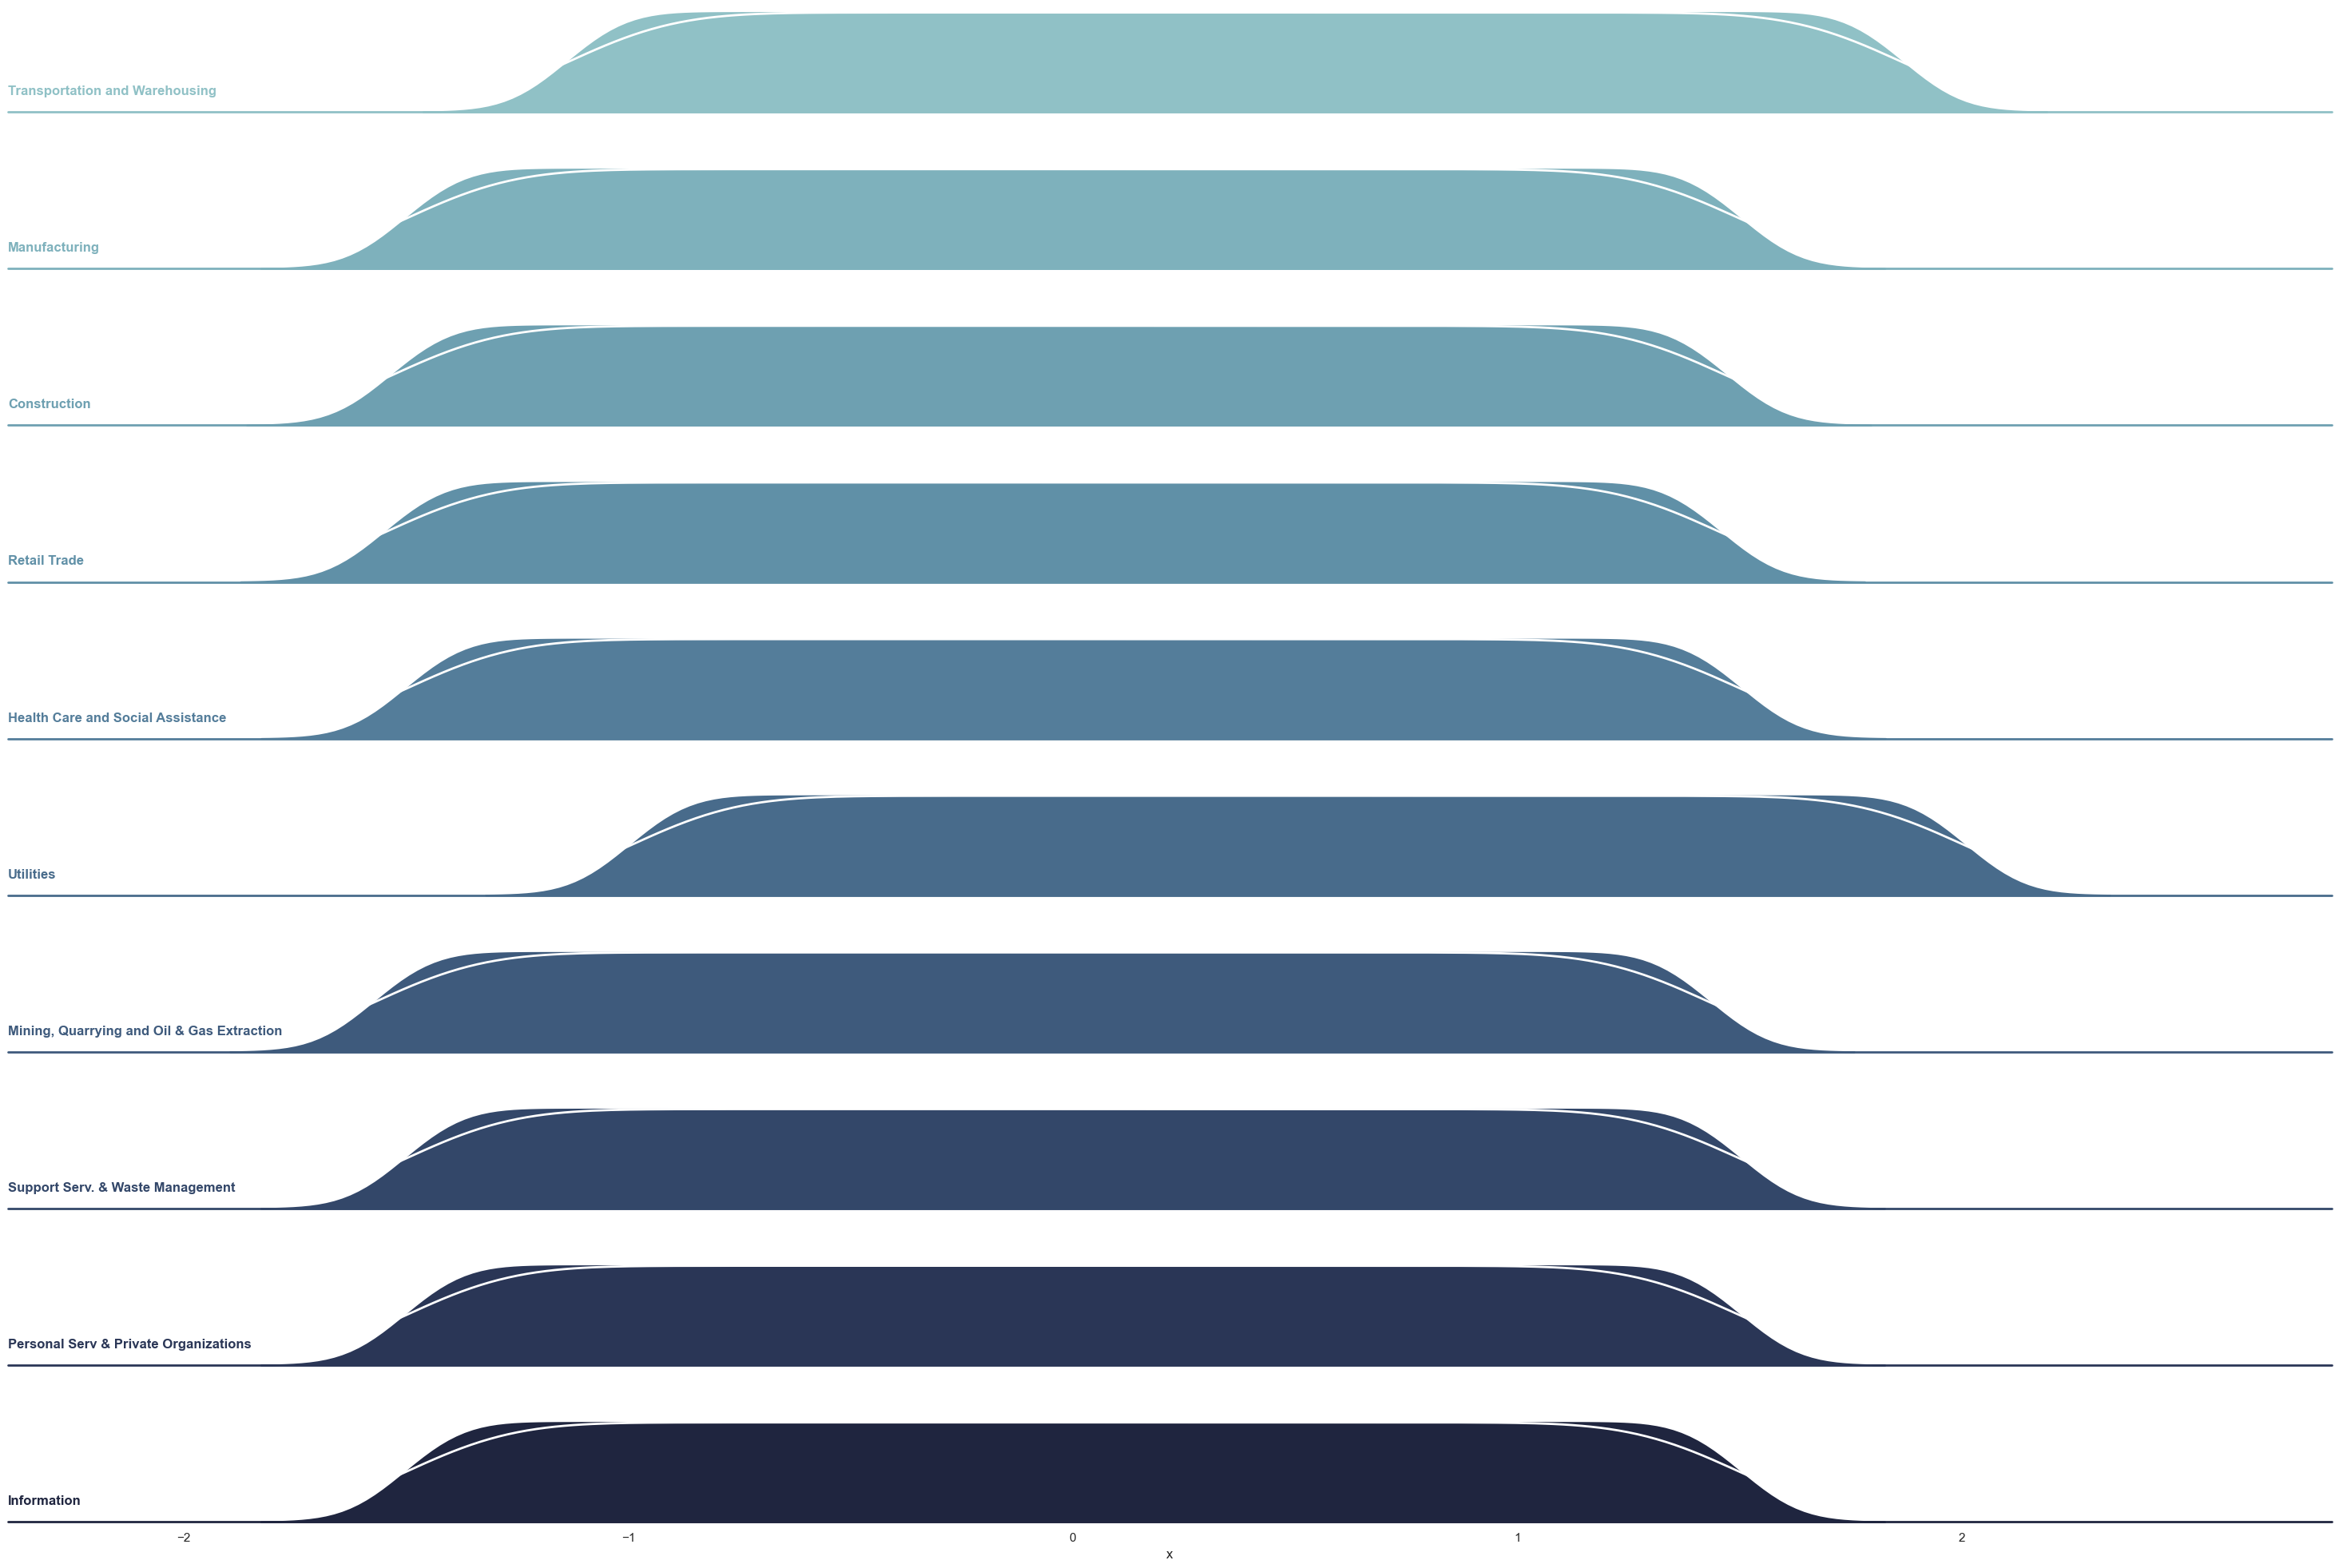

In [17]:
plot_data = pd.DataFrame()

for industry, row in industry_estimates.iterrows():
    if industry == 'Accommodation and Food Services':
        continue
    mu = row['ridle']
    sigma = row['s_ridle']
    # Ensure sigma is not too small to avoid zero variance
    sigma = max(sigma, 0.5)

    # Generating points for the bell curve with more points for smoothness
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)  # Increase the points for smoother curves
    y = norm.pdf(x, mu, sigma)

    # Append to the DataFrame
    temp_df = pd.DataFrame({'x': x, 'Density': y, 'Industry': industry})
    plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(len(industry_estimates) - 1, rot=-.25, light=.7)  # Exclude the skipped industry
# Adjust the height and aspect ratio for better spacing
g = sns.FacetGrid(plot_data, row="Industry", hue="Industry", aspect=15, height=2, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.9)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap less by adjusting hspace
g.figure.subplots_adjust(hspace=0.5)  # Increase vertical space between plots

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.show()

In [24]:
import altair as alt
alt.data_transformers.enable("vegafusion")

# Assuming plot_data is already created as per your provided code
for industry, row in industry_estimates.iterrows():
    if industry == 'Accommodation and Food Services':
        continue
    mu = row['ridle']
    sigma = row['s_ridle']
    # Ensure sigma is not too small to avoid zero variance
    sigma = max(sigma, 0.5)

    # Generating points for the bell curve with more points for smoothness
    x = np.linspace(mu - 1*sigma, mu + 3*sigma, 1000)  # Increase the points for smoother curves
    y = norm.pdf(x, mu, sigma)

    # Append to the DataFrame
    temp_df = pd.DataFrame({'x': x, 'Density': y, 'Industry': industry})
    plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

print(plot_data.head())
# Create a base chart
base = alt.Chart(plot_data).transform_density(
    'x',
    as_=['x', 'Density'],
    groupby=['Industry']
).mark_area().encode(
    x='x:Q',
    y='Density:Q',
    color='Industry:N'
)

# Facet by Industry
facet_chart = base.facet(
    row='Industry:N'
).properties(
    title='Density Plots by Industry'
)

facet_chart

        x  Density                        Industry
0 -1.1353   0.0089  Transportation and Warehousing
1 -1.1323   0.0090  Transportation and Warehousing
2 -1.1293   0.0092  Transportation and Warehousing
3 -1.1263   0.0094  Transportation and Warehousing
4 -1.1233   0.0095  Transportation and Warehousing


alt.FacetChart(...)

In [31]:
import pandas as pd
import altair as alt

# Creating the DataFrame from the provided data
data = {
    'Sector': [
        'Transportation and Warehousing', 'Manufacturing', 'Construction',
        'Accommodation and Food Services', 'Retail Trade',
        'Health Care and Social Assistance', 'Utilities',
        'Mining, Quarrying and Oil & Gas Extraction',
        'Support Serv. & Waste Management',
        'Personal Serv & Private Organizations', 'Information'
    ],
    'ridle': [0.3647, 0.0002, -0.0313, -0.0000, -0.0452, 0.0013, 0.5058, -0.0691, 0.0000, -0.0000, 0.0000],
    's_ridle': [0.1220, 0.0000, 0.0037, 9.1988, 0.0053, 0.0010, 0.0873, 0.0819, 0.1510, 0.0105, 0.0004],
    'p_ridle': [0.0028, 0.0000, 0.0000, 1.0000, 0.0000, 0.1922, 0.0000, 0.3984, 1.0000, 1.0000, 0.9170]
}

df = pd.DataFrame(data)

# Creating an Altair chart
chart = alt.Chart(df).mark_bar().encode(
    x='Sector:N',
    y='ridle:Q',
    color='Sector:N'
).properties(
    width=600,
    height=400
)

chart



alt.Chart(...)

In [42]:
data = {
    'Sector': [
        'Transportation and Warehousing', 'Manufacturing', 'Construction',
        'Retail Trade',
        'Health Care and Social Assistance', 'Utilities',
        'Mining, Quarrying and Oil & Gas Extraction',
        'Support Serv. & Waste Management',
        'Personal Serv & Private Organizations', 'Information'
    ],
    'ridle': [0.3647, 0.0002, -0.0313, -0.0452, 0.0013, 0.5058, -0.0691, 0.0000, -0.0000, 0.0000],
    's_ridle': [0.1220, 0.0000, 0.0037, 0.0053, 0.0010, 0.0873, 0.0819, 0.1510, 0.0105, 0.0004]
}
your_dataframe = pd.DataFrame(data)

std_dev = 0.05

bell_curves = pd.DataFrame()
for _, row in df.iterrows():
    mean = row['ridle']
    x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
    y = norm.pdf(x, mean, std_dev) / 5  # Adjust the height of the curve by scaling the y values
    temp_df = pd.DataFrame({'x': x, 'y': y, 'Sector': row['Sector']})
    bell_curves = pd.concat([bell_curves, temp_df])

# Visualization
chart = alt.Chart(bell_curves).mark_area(
    interpolate='monotone',
    fillOpacity=0.8,
    stroke='lightgray',
    strokeWidth=0.5
).encode(
    alt.X('x:Q', title='Value'),
    alt.Y('y:Q', axis=None, scale=alt.Scale(domain=[0, max(bell_curves['y'])])),  # Adjust domain for y-axis
    alt.Color('Sector:N', legend=None)  # Ensure color encoding is applied consistently
).facet(
    row=alt.Row('Sector:N', title=None, header=alt.Header(labelAngle=0, labelAlign='left'))
).properties(
    title='Bell Curves Centered Around Ridle Values',
    bounds='flush'
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)

chart

alt.FacetChart(...)

In [96]:

vfiltered_panel_data = filtered_panel_data[['Industry', 'return']]
# print(vfiltered_panel_data.head())
mask = vfiltered_panel_data['return'] == 0
mask2 = vfiltered_panel_data['Industry'] == 'Accommodation and Food Services'
mask3 = vfiltered_panel_data['Industry'] == 'Health Care and Social Assistance'
mask4 = vfiltered_panel_data['Industry'] == 'Information'
vfiltered_panel_data = vfiltered_panel_data[~mask]
vfiltered_panel_data = vfiltered_panel_data[~mask2]
vfiltered_panel_data = vfiltered_panel_data[~mask3]
vfiltered_panel_data = vfiltered_panel_data[~mask4]
# print(vfiltered_panel_data.shape)

df = vfiltered_panel_data
lower_bound = -1
upper_bound = 1

# Clip the 'return' values to be within the defined bounds
df['return'] = df['return'].clip(lower_bound, upper_bound)
mean_returns = df.groupby('Industry')['return'].mean().reset_index()

# Altair ridgeline plot
step = 30
overlap = 1

chart = alt.Chart(mean_returns, height=step).transform_density(
    density='return',
    groupby=['Industry'],
    as_=['return', 'density']
).mark_area(
    interpolate='monotone',
    fillOpacity=0.8,
    stroke='lightgray',
    strokeWidth=0.5
).encode(
    alt.X('return:Q', title='Average Return'),
    alt.Y('density:Q', axis=None, scale=alt.Scale(range=[step, -step * overlap])),
    alt.Fill('Industry:N')
).facet(
    row=alt.Row('Industry:N', title=None, header=alt.Header(labelAngle=0, labelAlign='left'))
).properties(
    title='Average Industry Returns',
    bounds='flush'
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)

chart

/var/folders/rp/y4zzq7f116jdmpzf6b0_rqn00000gn/T/ipykernel_10261/1487418687.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vfiltered_panel_data = vfiltered_panel_data[~mask2]
/var/folders/rp/y4zzq7f116jdmpzf6b0_rqn00000gn/T/ipykernel_10261/1487418687.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vfiltered_panel_data = vfiltered_panel_data[~mask3]
/var/folders/rp/y4zzq7f116jdmpzf6b0_rqn00000gn/T/ipykernel_10261/1487418687.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vfiltered_panel_data = vfiltered_panel_data[~mask4]


alt.FacetChart(...)

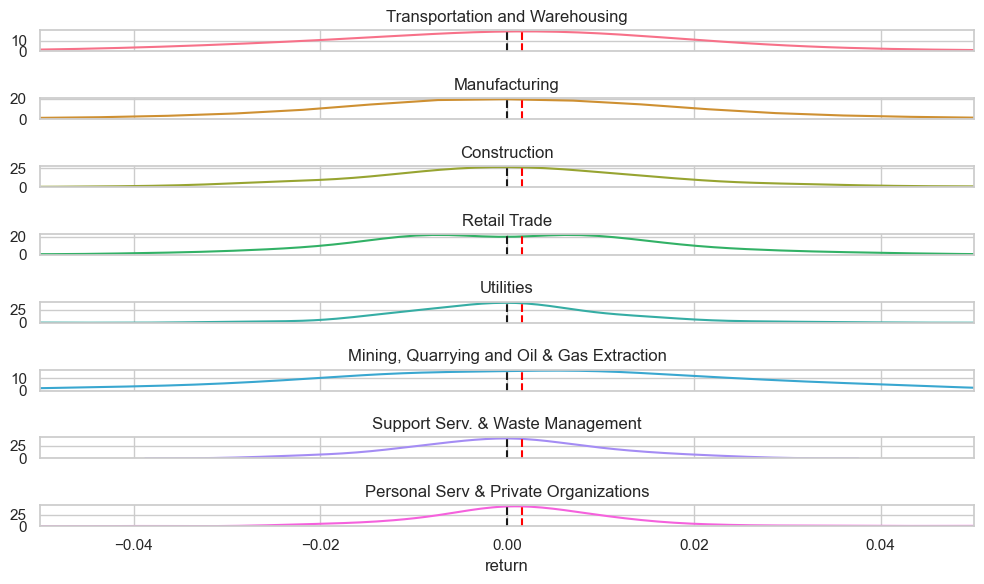

In [101]:
sns.set(style="whitegrid")
industries = df['Industry'].unique()
palette = sns.color_palette("husl", len(industries))
fig, axes = plt.subplots(len(industries), 1, figsize=(10, 6), sharex=True)

# Define x-axis limits
x_left_limit = -0.05 # replace with your desired limit
x_right_limit = 0.05 # replace with your desired limit

for i, industry in enumerate(industries):
    sns.kdeplot(df[df['Industry'] == industry]['return'], ax=axes[i], color=palette[i])
    axes[i].set_title(industry)
    axes[i].set_ylabel('')

    # Center the x-axis around 0 and set x-axis limits
    axes[i].axvline(0, color='k', linestyle='--') # Adds a vertical line at x=0
    axes[i].set_xlim(x_left_limit, x_right_limit)  # Sets x-axis limits

    mean_value = industry_data.mean()
    axes[i].axvline(mean_value, color='red', linestyle='--')

plt.tight_layout()
plt.show()

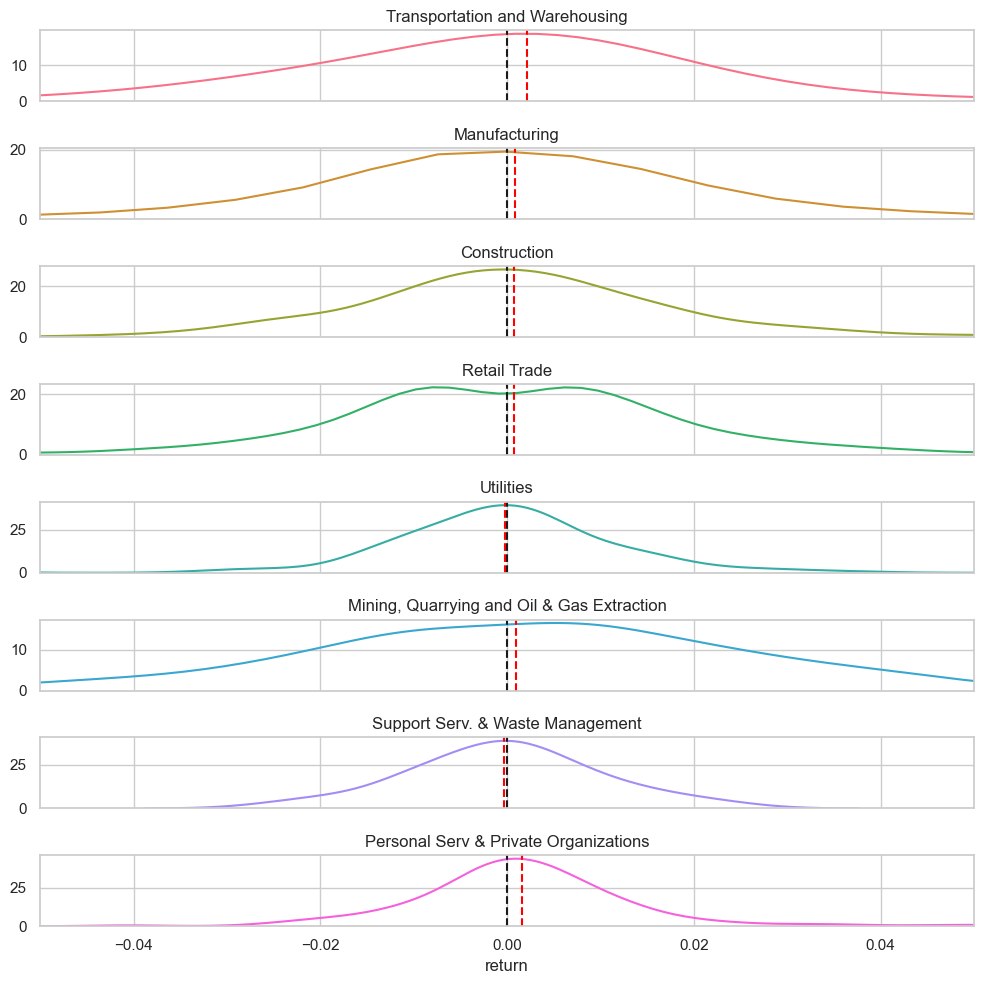

In [102]:
sns.set(style="whitegrid")
industries = df['Industry'].unique()
palette = sns.color_palette("husl", len(industries))

# Increase the height in the figsize tuple to make the vertical axis bigger
fig, axes = plt.subplots(len(industries), 1, figsize=(10, 10), sharex=True)  # Adjust the second value in figsize for height

x_left_limit = -0.05 # replace with your desired limit
x_right_limit = 0.05

for i, industry in enumerate(industries):
    industry_data = df[df['Industry'] == industry]['return']
    sns.kdeplot(industry_data, ax=axes[i], color=palette[i])
    axes[i].set_title(industry)
    axes[i].set_ylabel('')

    axes[i].axvline(0, color='k', linestyle='--') # Adds a vertical line at x=0
    axes[i].set_xlim(x_left_limit, x_right_limit)

    # Draw a vertical line at the mean of each industry's return
    mean_value = industry_data.mean()
    axes[i].axvline(mean_value, color='red', linestyle='--')  # Adds a red dashed line at the mean

plt.tight_layout()
plt.show()

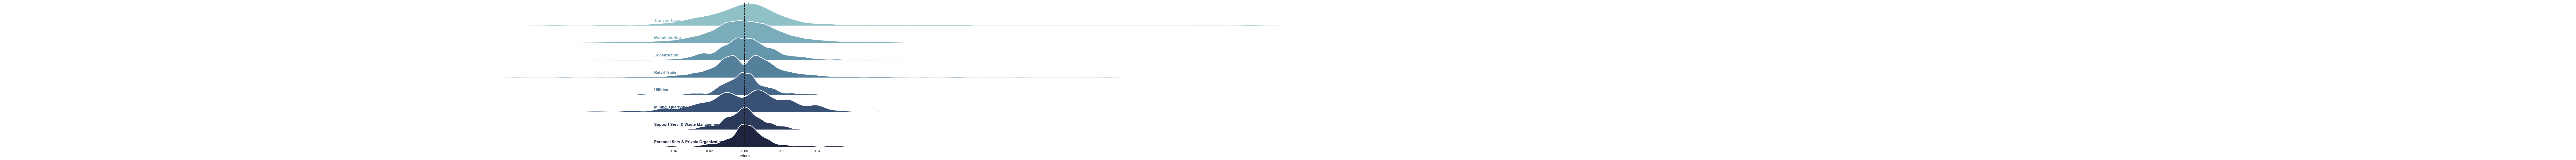

In [108]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Your DataFrame setup (assuming df is already defined)
industries = df['Industry'].unique()
pal = sns.cubehelix_palette(len(industries), rot=-.25, light=.7)

# Creating the subplots
fig, axes = plt.subplots(len(industries), 1, figsize=(10, len(industries)), sharex=True)

x_left_limit = -0.05 # replace with your desired limit
x_right_limit = 0.05

for i, industry in enumerate(industries):
    industry_data = df[df['Industry'] == industry]['return']
    mean_value = industry_data.mean()

    # KDE plot for each industry
    sns.kdeplot(industry_data, ax=axes[i], color=pal[i], 
                bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    sns.kdeplot(industry_data, ax=axes[i], clip_on=False, color="w", lw=2, bw_adjust=.5)

    # Adding a line at the mean
    axes[i].axvline(mean_value, color=pal[i], linestyle='--', linewidth=2)

    axes[i].axvline(0, color='k', linestyle='--') # Adds a vertical line at x=0
    axes[i].set_xlim(x_left_limit, x_right_limit)

    # Remove y-axis labels and ticks
    axes[i].set_ylabel('')
    axes[i].set_yticks([])

    # Set title as text within the plot
    axes[i].text(0, .2, industry, fontweight="bold", color=pal[i],
                 ha="left", va="center", transform=axes[i].transAxes)

# Adjust subplots to overlap and remove spines
fig.subplots_adjust(hspace=-.25)
sns.despine(bottom=True, left=True)

plt.show()

In [ ]:
vfiltered_panel_data = filtered_panel_data[['Industry', 'return', 'cum_returns', '5day_std','std_of_std', 'cum_returns', 'ra']]
print(vfiltered_panel_data.head())
mask = vfiltered_panel_data['return'] == 0 
vfiltered_panel_data = vfiltered_panel_data[~mask]
max_up 

In [115]:
data = panel_data
data['strike_diff'] = data['strike'].diff()

# Identifying the start and end of each strike
strike_starts = data[(data['strike'] == 1) & (data['strike_diff'] != 0)].index
strike_ends = data[(data['strike'] == 0) & (data['strike_diff'] != 0)].index

# Ensuring that the first strike start and last strike end are properly captured
if strike_starts[0] > strike_ends[0]:
    strike_ends = strike_ends[1:]
if strike_starts[-1] > strike_ends[-1]:
    strike_starts = strike_starts[:-1]

# Calculating the lengths of the strikes
strike_lengths = strike_ends - strike_starts
longest_strike_index = strike_lengths.argmax()

# Getting the start and end of the longest strike
longest_strike_start = strike_starts[longest_strike_index]
longest_strike_end = strike_ends[longest_strike_index]

# Sampling the data from this period
longest_strike_data = data.loc[longest_strike_start:longest_strike_end]

longest_strike_data.head(), longest_strike_data.tail(), longest_strike_data.shape

(                ISIN       Date  return  strike  ridle  cintensity  cratio  \
 345689  US4601461035 1987-03-23  0.0229  1.0000 0.0026      1.1220  1.4400   
 345690  US4601461035 1987-03-24 -0.0012  1.0000 0.0269      1.1220  1.4400   
 345691  US4601461035 1987-03-25  0.0047  1.0000 0.0269      1.1220  1.4400   
 345692  US4601461035 1987-03-26  0.0246  1.0000 0.0269      1.1220  1.4400   
 345693  US4601461035 1987-03-27 -0.0137  1.0000 0.0269      1.1220  1.4400   
 
           d2e  leadup  followup  5day_std  std_of_std  cum_returns  \
 345689 1.4400  0.0000    0.0000    0.7549      0.2647       1.8716   
 345690 1.4400  0.0000    0.0000    0.7549      0.2601       1.8682   
 345691 1.4400  0.0000    0.0000    0.5533      0.1734       1.8817   
 345692 1.4400  0.0000    0.0000    0.4465      0.1357       1.9527   
 345693 1.4400  0.0000    0.0000    0.3064      0.1957       1.9122   
 
         rolling_avg     spr       Industry     ra  strike_diff  
 345689      23.7520  0.0100  

In [122]:
from datetime import timedelta

# Getting the start date of the longest strike
longest_strike_start_date = longest_strike_data.iloc[0]['Date']

# Defining the period of one month before the strike and the first month of the strike
one_month_before_strike = longest_strike_start_date - timedelta(days=30)
first_month_of_strike = longest_strike_start_date + timedelta(days=30)

# Extracting the relevant data
month_before_data = data[(data['Date'] >= one_month_before_strike) & (data['Date'] < longest_strike_start_date)]
first_month_strike_data = data[(data['Date'] >= longest_strike_start_date) & (data['Date'] <= first_month_of_strike)]

# Concatenating the two periods for ease of plotting
volatility_period_data = pd.concat([month_before_data, first_month_strike_data])

# Calculating the rolling standard deviation of returns to represent volatility
# We use a rolling window of 5 days to calculate a short-term measure of volatility
volatility_period_data['volatility'] = volatility_period_data['return'].rolling(window=5).std()
volatility_period_data['volatility1'] = volatility_period_data['return'].rolling(window=2).std()


# Keeping only the relevant columns
volatility_period_data = volatility_period_data[['Date', 'volatility', 'volatility1']]

volatility_period_data.head(), volatility_period_data.tail(), volatility_period_data.shape



(          Date  volatility  volatility1
 924 1987-02-23         NaN          NaN
 925 1987-02-24         NaN       0.0000
 926 1987-02-25         NaN       0.0000
 927 1987-02-26         NaN       0.0000
 928 1987-02-27      0.0000       0.0000,
              Date  volatility  volatility1
 759401 1987-04-16      0.0387       0.0123
 759402 1987-04-17      0.0399       0.0491
 759403 1987-04-20      0.0424       0.0066
 759404 1987-04-21      0.0418       0.0132
 759405 1987-04-22      0.0369       0.0267,
 (4300, 3))

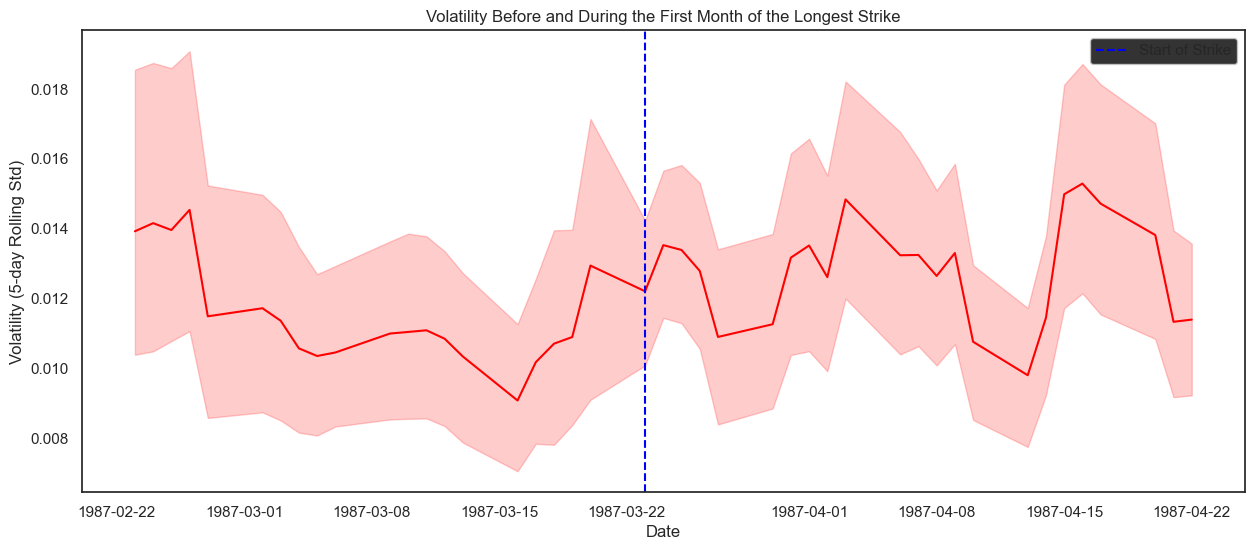

In [123]:
# Plotting the volatility
plt.figure(figsize=(15, 6))

# Plotting the volatility for the period before and during the strike
sns.lineplot(x='Date', y='volatility', data=volatility_period_data, color='red')

# Adding a vertical line to indicate the start of the strike
plt.axvline(longest_strike_start_date, color='blue', linestyle='--', label='Start of Strike')

# Adding labels and title
plt.title('Volatility Before and During the First Month of the Longest Strike')
plt.xlabel('Date')
plt.ylabel('Volatility (5-day Rolling Std)')
plt.legend()

# Show the plot
plt.show()


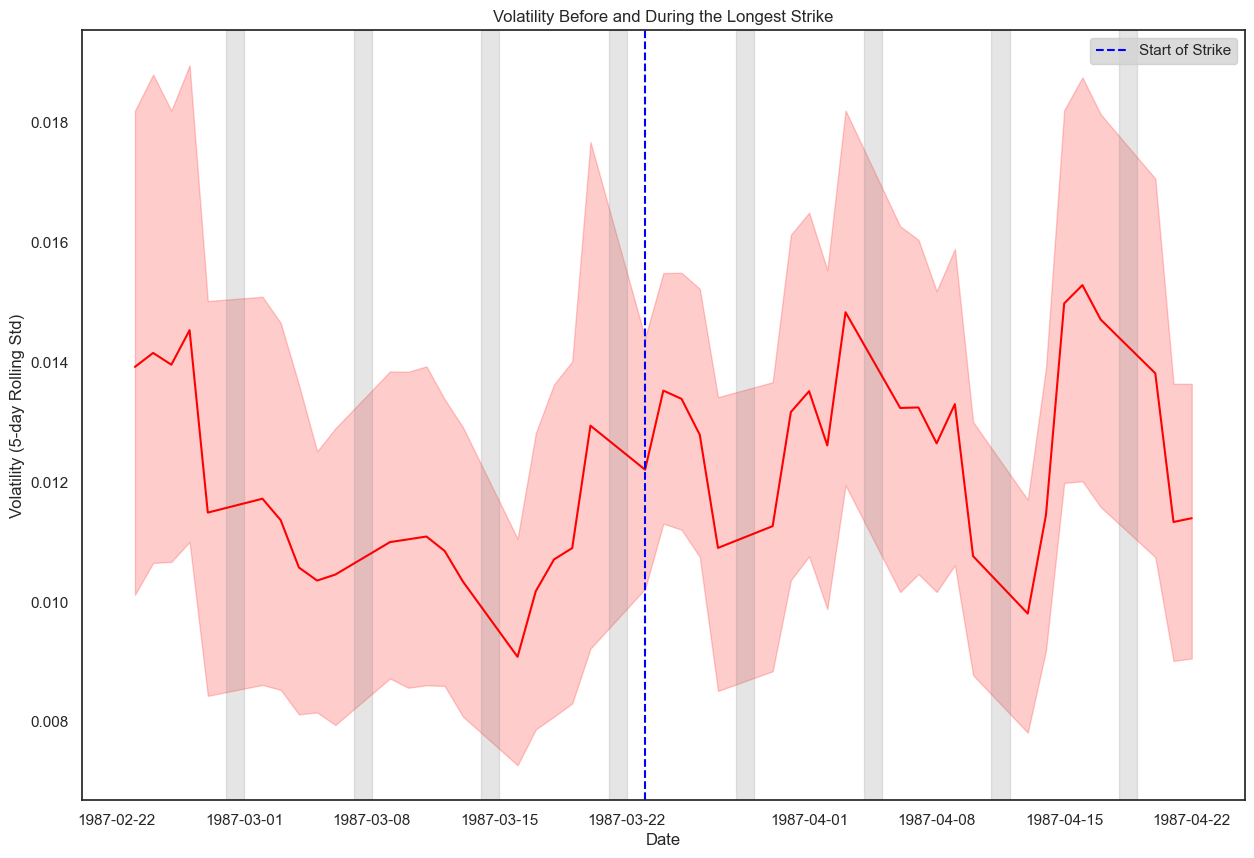

In [127]:
# Plotting the volatility with weekends shaded
plt.figure(figsize=(15, 10))

# Plotting the volatility for the period before and during the strike
sns.lineplot(x='Date', y='volatility', data=volatility_period_data, color='red')

# Adding a vertical line to indicate the start of the strike
plt.axvline(longest_strike_start_date, color='blue', linestyle='--', label='Start of Strike')

# Shading weekends
# We need to find all the weekends in the range and then shade them
min_date = volatility_period_data['Date'].min()
max_date = volatility_period_data['Date'].max()
weekends = pd.date_range(start=min_date, end=max_date, freq='W-SAT')  # Get all saturdays in the range

for weekend in weekends:
    plt.axvspan(weekend, weekend + timedelta(days=1), color='gray', alpha=0.2)

# Adding labels and title
plt.title('Volatility Before and During the Longest Strike')
plt.xlabel('Date')
plt.ylabel('Volatility (5-day Rolling Std)')
plt.legend(frameon=True, facecolor='lightgray')

# Show the plot
plt.show()
